In [135]:
# Add all the neccessary imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from functools import partial
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import preprocessor as p
from sklearn.model_selection import cross_val_score
from nltk.tokenize import TweetTokenizer
from clean_text import clean_text
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
sns.set_theme()



%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# Change setting to allow dataframe to be printed in full witdh
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

In [3]:
# Load the combined dataset
data = pd.read_csv('combined_election_reports.csv', encoding='utf-8')
data.shape

(126624, 9)

In [4]:
data.head()

id                           label  \
0    4.0  Polling Station Administration   
1    6.0  Polling Station Administration   
2  634.0                        Opinions   
3  637.0                        Opinions   
4  649.0                        Opinions   

                                                                                                                                                                          text  \
0                                                                                                           https://twitter.com/1146124540055052289/status/1541417316273246208   
1                                                                                                           https://twitter.com/1510781350902706180/status/1541412494526259202   
2  Elections are coming. Youths should turn up,vote and Preach peace before, during and after the Elections. We can never be used and divided for selfish Political Interests.   
3     It is important for youths to understand the election and voting processes, their role in the processes and how to ensure that peace is maintained even after elections.   
4                                Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities!   

      status                 date                         categories  \
0  published  2022-06-27 13:45:01  Polling station logistical issues   
1   archived  2022-06-27 13:25:51  Polling station logistical issues   
2  published  2022-07-05 05:08:29                     Peace messages   
3  published  2022-07-05 05:16:28                     Peace messages   
4  published  2022-07-05 07:19:47                  Positive Opinions   

   latitude  longitude Election Date  
0 -1.303169  36.826061   August 2022  
1 -1.283253  36.817245   August 2022  
2 -1.283253  36.817245   August 2022  
3 -1.303264  36.826384   August 2022  
4 -1.283253  36.817245   August 2022

In [5]:
# Filter out labelled data
labelled_data = data[data['label'] != 'Unstructured']

In [6]:
labelled_data.shape

(14563, 9)

In [7]:
labelled_data.sample(10)

id                 label  \
7615   22250.0       Staffing Issues   
10169  34782.0              Opinions   
9161   51385.0              Opinions   
331    58770.0  Counting and Results   
9970   32439.0       Positive Events   
10292  35346.0              Opinions   
8823   27883.0              Opinions   
6591   19694.0              Opinions   
2715   55428.0              Opinions   
7014   20348.0              Opinions   

                                                                                                                                                                                                                                                                                                                                                                         text  \
7615   Martin Sunkuli, Silas Njeru, Abdidahir Abdi Maalim and Gideon Ballang, all top IEBC managers are embroiled in the scam. They have also voted for increase in the legal department to pay pending bills to favourable law firms.THEY allegedly received bribes to award tenders to favoured firms and stashed the loot in their lawyers’ accounts or offshore accounts.   
10169                                                                                                                                                                                                                                                                 Why do we only rest in peace?\nWhy can't we live in peace too?\nWhy?\n#KenyaDecides \n#KenyaDecides2022   
9161                                                                                                                                                                             The law requires IEBC to declare the president-elect within seven days, the commission shall endeavour to conclude this exercise at the earliest time possible. @IEBCKenya #KenyaDecides2022   
331                                                                                                      Presidential RESULTS are in FORM 34(B). Constitution gives IEBC 7 days to ANNOUNCE. There are 291 FORM 34(B). Chebukati has ANNOUNCED only 1 form. From TOMORROW, he has to ANNOUNCE 60 Forms a day. 2 FORMS every 30 minutes. Will he BEAT constitutional DEADLINE?   
9970                                                                                                                                                                                    In a ruling made today, IEBC has been directed to complement the voters register with the manual one. Kenya kwanza alliance had opposed this move. What's your take? KenyaDecides2022   
10292                                                                                                                                   Rev. Canon Chris Kinyanjui @CKKamau ~ compares the Kenyan Elections to the world cup where the win take home the trophy while the rest of the teams go home empty handed.Such is the politics of Kenya where the winner takes it all.   
8823                                                                                                                                                                                                                                                                                Yes kuna swali liko apa nyamira watu wanaulisa hivi Raila akiwa raisi atawasadi kw sitima   
6591                                                                                                                                                                                                                                                                                                         Kwani KUZIMIA wanashindana na IEBC? Mara IEBC this, IEBC that...   
2715                                                                                                                                                                                                                                                      

In [8]:
labelled_data['date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 14563 entries, 0 to 126623
Series name: date
Non-Null Count  Dtype 
--------------  ----- 
14563 non-null  object
dtypes: object(1)
memory usage: 227.5+ KB


In [9]:
labelled_data['date'] = pd.to_datetime(labelled_data['date'])
labelled_data['date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 14563 entries, 0 to 126623
Series name: date
Non-Null Count  Dtype         
--------------  -----         
14563 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 227.5 KB


/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_30424/1042772584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data['date'] = pd.to_datetime(labelled_data['date'])


In [10]:
sorted_by_date_df = labelled_data.sort_values(by='date')

In [11]:
sorted_by_date_df.head(20)

id                 label  \
82189   53.0       Security Issues   
82213   78.0       Positive Events   
82221   86.0       Positive Events   
82222   87.0                 Other   
82227   93.0       Positive Events   
82230   96.0  Counting and Results   
82232  100.0       Security Issues   
82234  102.0                 Other   
82235  103.0                 Other   
82239  113.0     Political Rallies   
82251  135.0     Political Rallies   
82297  245.0     Political Rallies   
82282  227.0     Political Rallies   
82285  233.0     Political Rallies   
82242  117.0       Security Issues   
82243  118.0                 Other   
82254  141.0     Political Rallies   
82269  185.0     Political Rallies   
82265  177.0     Political Rallies   
82278  220.0     Political Rallies   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text  \
82189                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Hello,Eldoret siasa ni mbaya sana..alafu kuna mwenye amenitishia maisha.   
82213                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           PREACHING PEACE.JOSEPH FROM KILIBOTI   
82221                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Sealed ballot box tampered with   
82222                                                                                                                                                                                                                                                                                                                                                                                                                                                  People have arrived at Likuyani from different places. They have come to vote but surprisingly, they have carried several personal belongings, including clothing and bedding   
82227                                                                                                                              

In [12]:
test_samples = list(data['text'].sample(5))
test_samples

['@ahmednasirlaw 1. Voters having difficult to correctly identify their polling stations and or streams.\n2. Cases of Biometric machines not detecting the figure prints of the voters were high and\n3.  IEBC officials  turned away voters whose finger prints were not detected by the machines.',
 'you can’t convince me iebc is planning to conduct a see through election',
 'Reflections: Talking to the soul of a divided nation:\nDear Pendo #ElectionsKE #TheElephant\nhttps://t.co/JnUD6lCjf1',
 'Presiding officer counted votes for each candidate in an open manner and filled out the results on tallying sheet( Form 33)#RONGO',
 'This is the new Kenya.. The "Pride" of Africa #MagicalKenya #WomensRights #MediaShutdown #AbuseOfPower #impunity mo… https://t.co/4jueOgCM7O']

In [13]:
stoplist = stopwords.words('english')
my_stopwords = "usr url atuser st rd nd th am pm num multiexclamation multiquestion multistop" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
tokenizer = TweetTokenizer()

In [14]:
for ts in test_samples:
    print(clean_text(ts, tokenizer, stoplist) + "\n")

voter difficult correctli identifi poll station stream case biometr machin detect figur print voter high iebc offici turn away voter whose finger print detect machin

cant convinc iebc plan conduct see elect

reflect talk soul divid nation dear pendo electionsk theeleph

presid offic count vote candid open manner fill result talli sheet form rongo

new kenya pride africa magicalkenya womensright mediashutdown abuseofpow impun mo



In [15]:
# Apply the clean text function to the tweet column
labelled_data["clean_text"] = labelled_data["text"].apply(lambda text: clean_text(text, tokenizer, my_stopwords))

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_30424/425916389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["clean_text"] = labelled_data["text"].apply(lambda text: clean_text(text, tokenizer, my_stopwords))


In [16]:
labelled_data.head()

id                           label  \
0    4.0  Polling Station Administration   
1    6.0  Polling Station Administration   
2  634.0                        Opinions   
3  637.0                        Opinions   
4  649.0                        Opinions   

                                                                                                                                                                          text  \
0                                                                                                           https://twitter.com/1146124540055052289/status/1541417316273246208   
1                                                                                                           https://twitter.com/1510781350902706180/status/1541412494526259202   
2  Elections are coming. Youths should turn up,vote and Preach peace before, during and after the Elections. We can never be used and divided for selfish Political Interests.   
3     It is important for youths to understand the election and voting processes, their role in the processes and how to ensure that peace is maintained even after elections.   
4                                Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities!   

      status                date                         categories  latitude  \
0  published 2022-06-27 13:45:01  Polling station logistical issues -1.303169   
1   archived 2022-06-27 13:25:51  Polling station logistical issues -1.283253   
2  published 2022-07-05 05:08:29                     Peace messages -1.283253   
3  published 2022-07-05 05:16:28                     Peace messages -1.303264   
4  published 2022-07-05 07:19:47                  Positive Opinions -1.283253   

   longitude Election Date  \
0  36.826061   August 2022   
1  36.817245   August 2022   
2  36.817245   August 2022   
3  36.826384   August 2022   
4  36.817245   August 2022   

                                                                                                                                         clean_text  
0                                                                                                                                                    
1                                                                                                                                                    
2  elect are come youth should turn up vote and preach peac befor dure and after the elect we can never be use and divid for selfish polit interest  
3             it import for youth understand the elect and vote process their role in the process and how ensur that peac maintain even after elect  
4                             vote just one of the mani way young peopl can make their voic heard have an impact issu that affect them their commun

In [17]:
# Replace empty rows after cleaning with nans
labelled_data['clean_text'].replace('', np.nan, inplace=True)
labelled_data.dropna(subset=['clean_text'], inplace=True)

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_30424/1628289420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data['clean_text'].replace('', np.nan, inplace=True)
/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_30424/1628289420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data.dropna(subset=['clean_text'], inplace=True)


In [18]:
labelled_data.shape

(14304, 10)

In [19]:
labelled_data.sample(5)

id                 label  \
6065    18708.0              Opinions   
4625    25259.0       Positive Events   
10816   41142.0              Opinions   
11039   43223.0              Opinions   
123430  35300.0  Counting and Results   

                                                                                                                                                                                                                                                                                                    text  \
6065                               During the presidential elections petition in 2017, IEBC was asked by the Supreme Court to open the servers but argue the French firm OT-Morpho was asleep. Today, 14days to elections IEBC continues to release press statements at night when Kenyan’s are a sleep.   
4625    2/\nMr.\n@RoySasaka\n urged youth to come out in large numbers and elect leaders who will prioritize youth interests.He as well emphasized the need for youth to accomplish their generational course of championing peace, especially during #GE2022.\n@MoICTKenya\n\n#SautiYetu\n\n(#Ourvoice)   
10816                                                                Tomorrow is the day for Kenyans to make their choice on who will lead them for the next 5 years. Let's Join hand's and vote for his excellency WSR @WilliamsRuto\n\nVote\nVote peaceful\n\nDr.william Ruto\nPanic\nIEBC\n#TukoWengi   
11039                                                                                                                                                                                       Decision time: D-Day as Kenyans go to the polls https://bit.ly/3JInZPy \n\n#KenyaDecides \n#KenyaDecides2022   
123430                                                                                                                                                                                                     You use numbers to work out a percentage..\nSo what is chebukati saying?\n#ElectionsBoycottKE   

           status                date  \
6065    published 2022-07-26 07:32:50   
4625    published 2022-07-30 13:55:44   
10816   published 2022-08-08 13:32:57   
11039   published 2022-08-09 02:53:12   
123430   archived 2017-10-26 19:40:04   

                                                                                               categories  \
6065                                                                                     Personal Opinion   
4625                                                                                                  NaN   
10816                                                                                    Personal Opinion   
11039                                                                                    Personal Opinion   
123430  Counting Irregularities,Provisional Citizen Results,Failure to announce results by IEBC officials   

        latitude  longitude Election Date  \
6065   -1.283253  36.817245   August 2022   
4625   -1.286116  36.827908   August 2022   
10816  -1.199406  36.890114   August 2022   
11039  -1.292066  36.821946   August 2022   
123430  1.441968  38.431398  October 2017   

                                                                                                                                                                                                             clean_text  
6065    dure the presidenti elect petit in iebc wa ask by the suprem court open the server but argu the french firm ot morpho wa asleep today day elect iebc continu releas press statement night when kenyan are sleep  
4625          mr urg youth come out in larg number and elect leader who will priorit youth interest he as well emphas the need for youth accomplish their gener cours of champion peac especi dure ge sautiyetu ourvoic  
10816                                     tomorrow the day for kenyan make their choic who will lead them for the next year let join hand 

In [20]:
labelled_data['word_count'] = labelled_data['clean_text'].apply(lambda x: len(tokenizer.tokenize(x)))

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_30424/2535994027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data['word_count'] = labelled_data['clean_text'].apply(lambda x: len(tokenizer.tokenize(x)))


In [21]:
# Look at the count distribution
labelled_data.head()

id     label  \
2  634.0  Opinions   
3  637.0  Opinions   
4  649.0  Opinions   
5  650.0  Opinions   
7  656.0  Opinions   

                                                                                                                                                                                                                                                                     text  \
2                                                                                             Elections are coming. Youths should turn up,vote and Preach peace before, during and after the Elections. We can never be used and divided for selfish Political Interests.   
3                                                                                                It is important for youths to understand the election and voting processes, their role in the processes and how to ensure that peace is maintained even after elections.   
4                                                                                                                           Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities!   
5                                                                                 Let's all stand out as youth to be agents of change by spreading the message of peace across all the borders within Kenya. Make an impact. There is elections and life after elections.   
7  Quite critical indeed @ItsKimaniThomas\nThe active and meaningful participation of young people in the Kenya General elections #GE2022 requires the precedent of voter education which also translates to an inclusive transparent process for peace in the elections.   

      status                date         categories  latitude  longitude  \
2  published 2022-07-05 05:08:29     Peace messages -1.283253  36.817245   
3  published 2022-07-05 05:16:28     Peace messages -1.303264  36.826384   
4  published 2022-07-05 07:19:47  Positive Opinions -1.283253  36.817245   
5  published 2022-07-05 07:15:02     Peace messages -1.283253  36.817245   
7  published 2022-07-05 08:47:59            Neutral -1.303264  36.826384   

  Election Date  \
2   August 2022   
3   August 2022   
4   August 2022   
5   August 2022   
7   August 2022   

                                                                                                                                                                                        clean_text  \
2                                                 elect are come youth should turn up vote and preach peac befor dure and after the elect we can never be use and divid for selfish polit interest   
3                                                            it import for youth understand the elect and vote process their role in the process and how ensur that peac maintain even after elect   
4                                                                            vote just one of the mani way young peopl can make their voic heard have an impact issu that affect them their commun   
5                                     let all stand out as youth be agent of chang by spread the messag of peac across all the border within kenya make an impact there elect and life after elect   
7  quit critic inde the activ and meaning particip of young peopl in the kenya gener elect ge requir the preced of voter educ which also translat an inclus transpar process for peac in the elect   

   word_count  
2          28  
3          24  
4          23  
5          31  
7          35

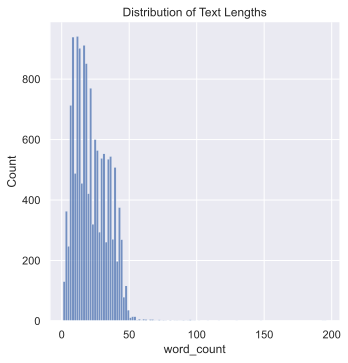

In [22]:
# Visualise word count distribution
sns.displot(labelled_data, x="word_count")
plt.title('Distribution of Text Lengths')
plt.show()

In [23]:
labelled_data['word_count'].describe()

count    14304.000000
mean        22.126608
std         12.682611
min          1.000000
25%         12.000000
50%         20.000000
75%         32.000000
max        196.000000
Name: word_count, dtype: float64

In [26]:
max_length_row = labelled_data.loc[labelled_data['word_count'].idxmax()]
print(max_length_row)

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [27]:
# Analyse the proportion of data that has less than 5 tokens after cleaning the data - similar to the BERT example for checking 
lengths_en = labelled_data['word_count'].to_numpy()

min_len = 3

# Count the number of sequences that are longer than `max_len` tokens.
num_truncated = np.sum(np.less(lengths_en, min_len))

# Compare this to the total number of training sentences.
num_sentences = len(lengths_en)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are shorter than {:} tokens.'.format(num_truncated, num_sentences, prcnt, min_len))

130 of 14,304 sentences (0.9%) in the training set are shorter than 3 tokens.


In [28]:
# Drop all instances of text that are less than 3 tokens as they may not provide any useful information
# Drop rows where any column has a value less than the threshold
labelled_data = labelled_data.drop(labelled_data[labelled_data['word_count'] < min_len].index)

In [29]:
labelled_data.shape

(14174, 11)

In [31]:
# Merge labels in the dataset
labelled_data["merged_label"] = labelled_data['label'].replace({'Polling Station Administration':"Voting Issues",'Staffing Issues':"Voting Issues", "Voting Issues":"Voting Issues", "Opinions":"Other"})

In [32]:
labelled_data["merged_label"].unique()

array(['Other', 'Political Rallies', 'Positive Events', 'Security Issues',
       'Voting Issues', 'Counting and Results'], dtype=object)

In [38]:
# Create informative vs non-informative features
labelled_data["informative_label"] = labelled_data['merged_label'].replace({'Voting Issues':"Informative",'Political Rallies':"Informative", 
                                                                     "Positive Events":"Informative", "Other":"Non-Informative", 
                                                                     "Counting and Results":"Informative", "Security Issues":"Informative"})

In [39]:
labelled_data["informative_label"].unique()

array(['Non-Informative', 'Informative'], dtype=object)

In [41]:
informative_le = preprocessing.LabelEncoder()
informative_le.fit(labelled_data['informative_label'])
labelled_data['informative_target'] = informative_le.transform(labelled_data['informative_label'])
labelled_data[['clean_text', 'informative_target']].head()

clean_text  \
2                                                 elect are come youth should turn up vote and preach peac befor dure and after the elect we can never be use and divid for selfish polit interest   
3                                                            it import for youth understand the elect and vote process their role in the process and how ensur that peac maintain even after elect   
4                                                                            vote just one of the mani way young peopl can make their voic heard have an impact issu that affect them their commun   
5                                     let all stand out as youth be agent of chang by spread the messag of peac across all the border within kenya make an impact there elect and life after elect   
7  quit critic inde the activ and meaning particip of young peopl in the kenya gener elect ge requir the preced of voter educ which also translat an inclus transpar process for peac in the elect   

   informative_target  
2                   1  
3                   1  
4                   1  
5                   1  
7                   1

In [92]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()

In [93]:
# Normalise the tweet using BERT tweet to see perfromance
# Add normalisation function
def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [95]:
test_samples = list(labelled_data['text'].sample(5))
test_samples

['a) Uhuruto endorsed Mandago for the governor seat and requested Buzeki to support Mandago                                \nb) Promised to improve road networks and schools as well as boldster security',
 'Results Transmission System (RTS) Application Workflow.',
 "If you get hit on the head by Azziad, are you sure you'll recover ?",
 'Party agents failed to agree on rejected ballot papers#Awendo',
 'Im willing to protest against the person i voted for should they fall short on their pledges, anyone else is the problem of the person that voted for them \nBenji #VoteThemOut Sugoi Makueni #IEBC']

In [96]:
for ts in test_samples:
    print(normalizeTweet(ts) + "\n")

a ) Uhuruto endorsed Mandago for the governor seat and requested Buzeki to support Mandago b ) Promised to improve road networks and schools as well as boldster security

Results Transmission System ( RTS ) Application Workflow .

If you get hit on the head by Azziad , are you sure you 'll recover ?

Party agents failed to agree on rejected ballot papers #Awendo

Im willing to protest against the person i voted for should they fall short on their pledges , anyone else is the problem of the person that voted for them Benji #VoteThemOut Sugoi Makueni #IEBC



In [97]:
labelled_data['normalized_text'] = labelled_data['clean_text'].map(normalizeTweet)

In [98]:
# Start the first baseline of just using sentence embeddings

In [99]:
labelled_data.shape

(14174, 15)

In [100]:
# Import sentence transformers lib package
from sentence_transformers import SentenceTransformer

In [102]:
# Potentially consider using another sentence transformer - used distil bert
embedder = SentenceTransformer('sentence-transformers/LaBSE')

In [103]:
sentences = labelled_data.text.values
targets = labelled_data.informative_target.values
informative_labels = labelled_data.informative_label.values
merged_labels = labelled_data.merged_label.values

In [104]:
print(sentences.shape, targets.shape)

(14174,) (14174,)


In [105]:
# Map the sentences to vector space using embedder - this code takes a while to run
embeddings = embedder.encode(sentences) # Probably save the embeddings - save the embeddings to like a pickle or something - took 30 minutes to run 

In [106]:
# Check the dimension size of the embeddings
print(f"The length of the embeddings is {len(embeddings[0])}")

The length of the embeddings is 768


In [107]:
# Plot a tsne to get a visual depiction of the two
# Add specific imports for tsne 
from sklearn.manifold import TSNE

In [108]:
# Apply t-SNE to reduce the dimensionality of embeddings to 2
tsne = TSNE(n_components=2, random_state=42,  perplexity=5, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

In [110]:
# Create a scatter plot of the t-SNE embeddings
plt.figure(figsize=(8, 6))
for label in np.unique(informative_labels):
    indices = np.where(informative_labels == label)
    plt.scatter(
        embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(label), alpha=0.7
    )
plt.title("t-SNE Plot of Embeddings")
plt.legend()
plt.show()

In [111]:
# Multi-label TSNE visualisation

In [112]:
# Create a scatter plot of the t-SNE embeddings
plt.figure(figsize=(8, 6))
for label in np.unique(merged_labels):
    indices = np.where(merged_labels == label)
    plt.scatter(
        embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(label), alpha=0.7
    )
plt.title("t-SNE Plot of Embeddings")
plt.legend()
plt.show()

In [113]:
# Split the data to train and test
train_embeddings, test_embeddings, train_targets, test_targets = train_test_split(embeddings, 
                                                                            targets, 
                                                                            test_size=0.20, 
                                                                            random_state=0)

In [209]:
model_svc = SVC(class_weight='balanced', C=0.1)
model_svc.fit(train_embeddings, train_targets)

SVC(C=0.1, class_weight='balanced')

In [165]:
model_svc.get_params()

{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [166]:
#Calculating predictions, and accuracy score
pred_svc = model_svc.predict(test_embeddings)
accuracy_score(test_targets, pred_svc)

0.7601410934744268

In [168]:
#Building classification report
print(classification_report(test_targets,pred_svc))

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       981
           1       0.85      0.77      0.81      1854

    accuracy                           0.76      2835
   macro avg       0.74      0.75      0.74      2835
weighted avg       0.77      0.76      0.76      2835



In [169]:
#Util function to plot confusion matrix
def plot_cm(labels, predictions, class_labels):
    # predictions has values in [0,1]
    cm = confusion_matrix(labels, predictions)
    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)
    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format   
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers. 
    ax = sns.heatmap(cm, annot=True, fmt='d', )
    # set x-axis label and ticks. 

  # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
    ax.set_xticklabels(class_labels, rotation=45, ha='right')

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", fontsize=14, labelpad=20)
    ax.set_yticklabels(class_labels, rotation=45, ha='right')

    # set plot title
    ax.set_title("Confusion Matrix", fontsize=14, pad=20)

    plt.show()

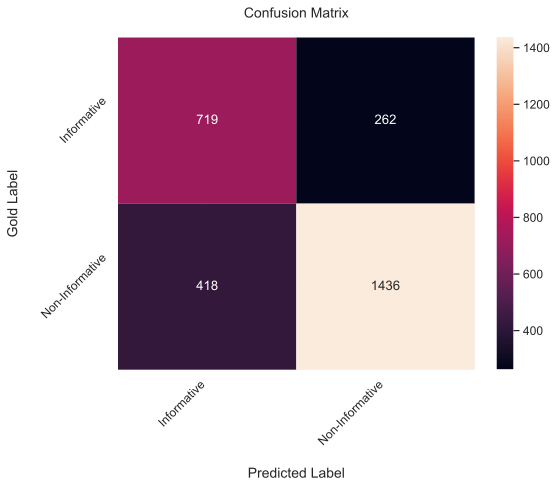

In [170]:
plot_cm(test_targets, pred_svc, np.unique(informative_labels))

In [194]:
model_lsvc = LinearSVC(class_weight='balanced', C=0.1)
model_lsvc.fit(train_embeddings, train_targets)

LinearSVC(C=0.1, class_weight='balanced')

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       981
           1       0.86      0.78      0.82      1854

    accuracy                           0.77      2835
   macro avg       0.75      0.77      0.75      2835
weighted avg       0.78      0.77      0.77      2835



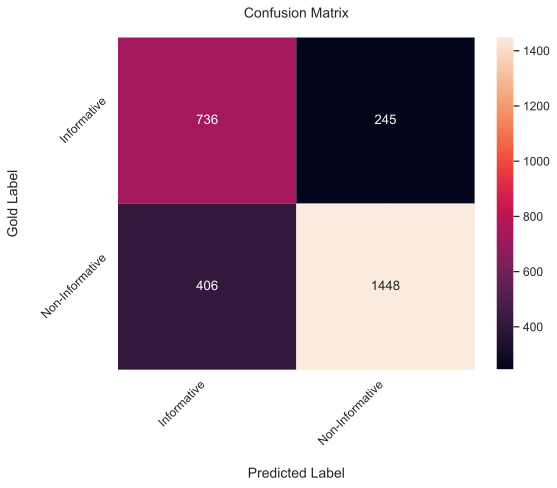

In [195]:
#Calculating predictions, and accuracy score
pred_lsvc = model_lsvc.predict(test_embeddings)
accuracy_score(test_targets, pred_lsvc)
#Building classification report
print(classification_report(test_targets,pred_lsvc))
plot_cm(test_targets, pred_lsvc, np.unique(informative_labels))

In [136]:
# Hyper parameter tuning fror SVC Using simple GridSearchCV
svc = SVC(class_weight='balanced')
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
clf = GridSearchCV(svc,param_grid)

In [185]:
model_lr = LogisticRegression(class_weight='balanced')
model_lr.fit(train_embeddings, train_targets)

LogisticRegression(class_weight='balanced')

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       981
           1       0.86      0.78      0.82      1854

    accuracy                           0.77      2835
   macro avg       0.75      0.76      0.75      2835
weighted avg       0.78      0.77      0.77      2835



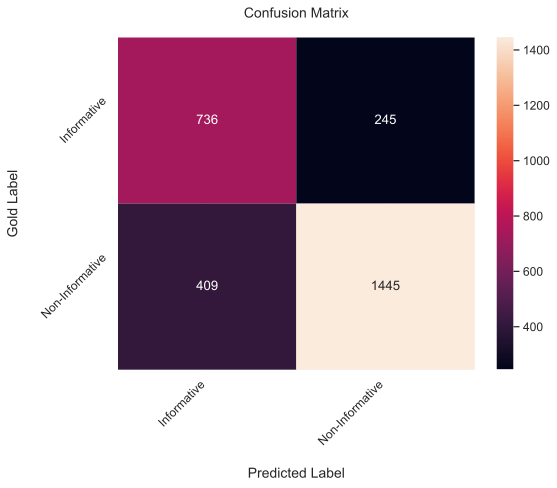

In [186]:
#Calculating predictions, and accuracy score
pred_lr = model_lr.predict(test_embeddings)
accuracy_score(test_targets, pred_lr)
#Building classification report
print(classification_report(test_targets,pred_lr))
plot_cm(test_targets, pred_lr, np.unique(informative_labels))

In [176]:
model_lr.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [187]:
from sklearn.linear_model import LogisticRegressionCV

In [206]:
clf = LogisticRegressionCV(cv=5, random_state=0, class_weight='balanced', scoring='recall_macro').fit(train_embeddings, train_targets)

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       981
           1       0.85      0.78      0.82      1854

    accuracy                           0.77      2835
   macro avg       0.75      0.76      0.75      2835
weighted avg       0.78      0.77      0.77      2835



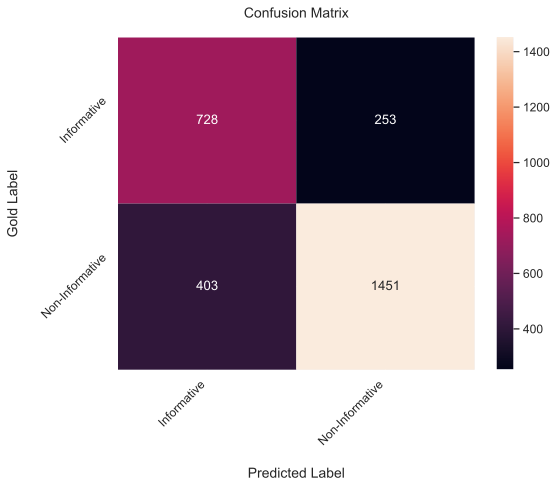

In [207]:
pred_clf = clf.predict(test_embeddings)
accuracy_score(test_targets, pred_clf)
#Building classification report
print(classification_report(test_targets,pred_clf))
plot_cm(test_targets, pred_clf, np.unique(informative_labels))

In [147]:
model_rf = RandomForestClassifier(class_weight='balanced', n_estimators=250)
model_rf.fit(train_embeddings, train_targets)

RandomForestClassifier(class_weight='balanced', n_estimators=250)

              precision    recall  f1-score   support

           0       0.80      0.42      0.55       981
           1       0.76      0.94      0.84      1854

    accuracy                           0.76      2835
   macro avg       0.78      0.68      0.70      2835
weighted avg       0.77      0.76      0.74      2835



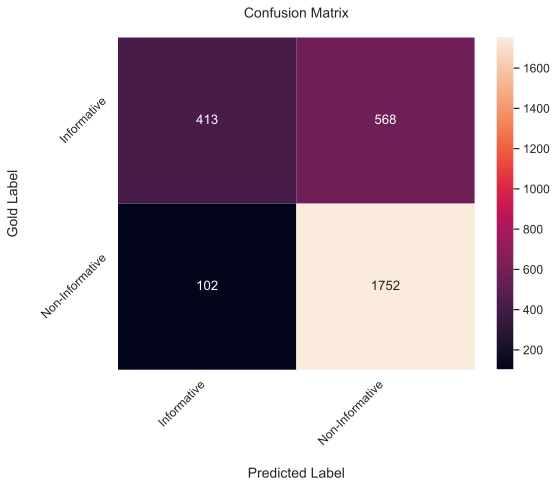

In [148]:
#Calculating predictions, and accuracy score
pred_rf = model_rf.predict(test_embeddings)
accuracy_score(test_targets, pred_rf)
#Building classification report
print(classification_report(test_targets,pred_rf))
plot_cm(test_targets, pred_rf, np.unique(informative_labels))

In [149]:
import xgboost as xgb

In [150]:
model_xg = xgb.XGBClassifier(class_weight='balanced')
model_xg.fit(train_embeddings, train_targets)

[13:12:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       981
           1       0.79      0.88      0.83      1854

    accuracy                           0.77      2835
   macro avg       0.75      0.72      0.73      2835
weighted avg       0.76      0.77      0.76      2835



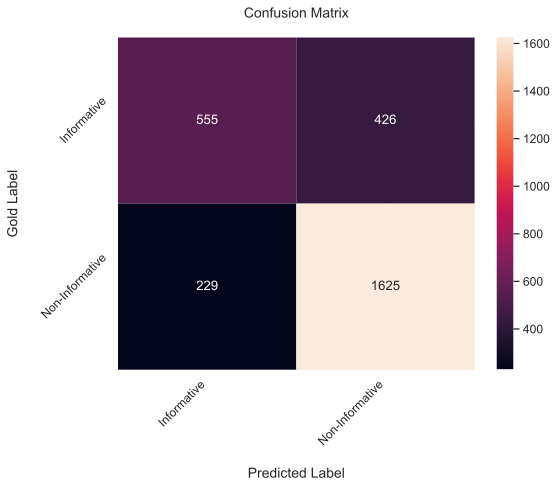

In [151]:
#Calculating predictions, and accuracy score
pred_xg = model_xg.predict(test_embeddings)
accuracy_score(test_targets, pred_xg)
#Building classification report
print(classification_report(test_targets,pred_xg))
plot_cm(test_targets, pred_xg, np.unique(informative_labels))

In [208]:
# Conclusively compare LinearSVC and Logistic Regression

# SVM
scores = cross_val_score(model_lsvc, train_embeddings, train_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

Average F1 Score: 0.7526744274550332
Individual F1 Scores: [0.75679857 0.76127717 0.75302989 0.74278009 0.74948641]


In [210]:
# Conclusively compare LinearSVC and Logistic Regression

# SVM
scores = cross_val_score(model_lr, train_embeddings, train_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

Average F1 Score: 0.7521168648654093
Individual F1 Scores: [0.7572117  0.76134881 0.752441   0.74288608 0.74669673]


In [211]:
# Take the Balanced Linear SVC modeel as the baseline to compare adding new features

In [212]:
labelled_data[['text','clean_text', 'date', ]].head()

id     label  \
2  634.0  Opinions   
3  637.0  Opinions   
4  649.0  Opinions   
5  650.0  Opinions   
7  656.0  Opinions   

                                                                                                                                                                                                                                                                     text  \
2                                                                                             Elections are coming. Youths should turn up,vote and Preach peace before, during and after the Elections. We can never be used and divided for selfish Political Interests.   
3                                                                                                It is important for youths to understand the election and voting processes, their role in the processes and how to ensure that peace is maintained even after elections.   
4                                                                                                                           Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities!   
5                                                                                 Let's all stand out as youth to be agents of change by spreading the message of peace across all the borders within Kenya. Make an impact. There is elections and life after elections.   
7  Quite critical indeed @ItsKimaniThomas\nThe active and meaningful participation of young people in the Kenya General elections #GE2022 requires the precedent of voter education which also translates to an inclusive transparent process for peace in the elections.   

      status                date         categories  latitude  longitude  \
2  published 2022-07-05 05:08:29     Peace messages -1.283253  36.817245   
3  published 2022-07-05 05:16:28     Peace messages -1.303264  36.826384   
4  published 2022-07-05 07:19:47  Positive Opinions -1.283253  36.817245   
5  published 2022-07-05 07:15:02     Peace messages -1.283253  36.817245   
7  published 2022-07-05 08:47:59            Neutral -1.303264  36.826384   

  Election Date  \
2   August 2022   
3   August 2022   
4   August 2022   
5   August 2022   
7   August 2022   

                                                                                                                                                                                        clean_text  \
2                                                 elect are come youth should turn up vote and preach peac befor dure and after the elect we can never be use and divid for selfish polit interest   
3                                                            it import for youth understand the elect and vote process their role in the process and how ensur that peac maintain even after elect   
4                                                                            vote just one of the mani way young peopl can make their voic heard have an impact issu that affect them their commun   
5                                     let all stand out as youth be agent of chang by spread the messag of peac across all the border within kenya make an impact there elect and life after elect   
7  quit critic inde the activ and meaning particip of young peopl in the kenya gener elect ge requir the preced of voter educ which also translat an inclus transpar process for peac in the elect   

   word_count merged_label informative_label  informative_target  \
2          28        Other   Non-Informative                   1   
3          24        Other   Non-Informative                   1   
4          23        Other   Non-Informative                   1   
5          31        Other   Non-Informative                   1   
7          35        Other   Non-Informative                   1   

                                                                                        